# Analysis of Ar39 simulations by CJ
In this notebook, we aim to analyse the simulations of 1e6 Ar39 decays.
Since this is a preliminary study, we will structure the analysis as:
- Analysis of energy spectrum, in particular energy deposited in Ar39 and energy detected.
- Analysis of time, aiming to highlight when occur the higher energy depositions.
- Analsysi of space to see the localization of energy deposition with respect to the original starting point of decay.


In [2]:
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [25, 15]
plt.rcParams.update({'font.size': 18})

In [3]:
# Load Ar39 data
dir_in = os.path.join("..", "Data", "ar39")
filename = "all_ar39.csv"

df = pd.read_csv(os.path.join(dir_in, filename), index_col=False)
df.head()    # Show preview

,PID,ParentTrackID,energydeposition,kineticenergy,time,x,y,z,px,py,pz,eventnumber,tracknumber,creatorprocess,parentnucleusPID
0,11,1,199.602808,0.0,10965981533621045248,145.475123,-41.761746,876.506390,0.329759,0.138789,0.933808,0,4,eIoni,1000180390
1,1000190390,1,0.007450,0.0,10965981533621045248,145.475123,-41.761746,876.506390,-0.003431,-0.453118,-0.891444,0,2,ionIoni,1000190390
2,11,1,127.671402,0.0,7978349220669757440,305.754361,32.901259,-35.512578,0.149663,-0.759912,0.632562,1,4,eIoni,1000180390
3,1000190390,1,0.007276,0.0,7978349220669757440,305.754361,32.901259,-35.512578,-0.528607,0.798146,-0.289028,1,2,ionIoni,1000190390
4,11,1,22.204675,0.0,12169737727684888576,309.174425,112.813957,48.999119,0.097874,0.828458,-0.551433,3,4,eIoni,1000180390


## Analsysis of energy

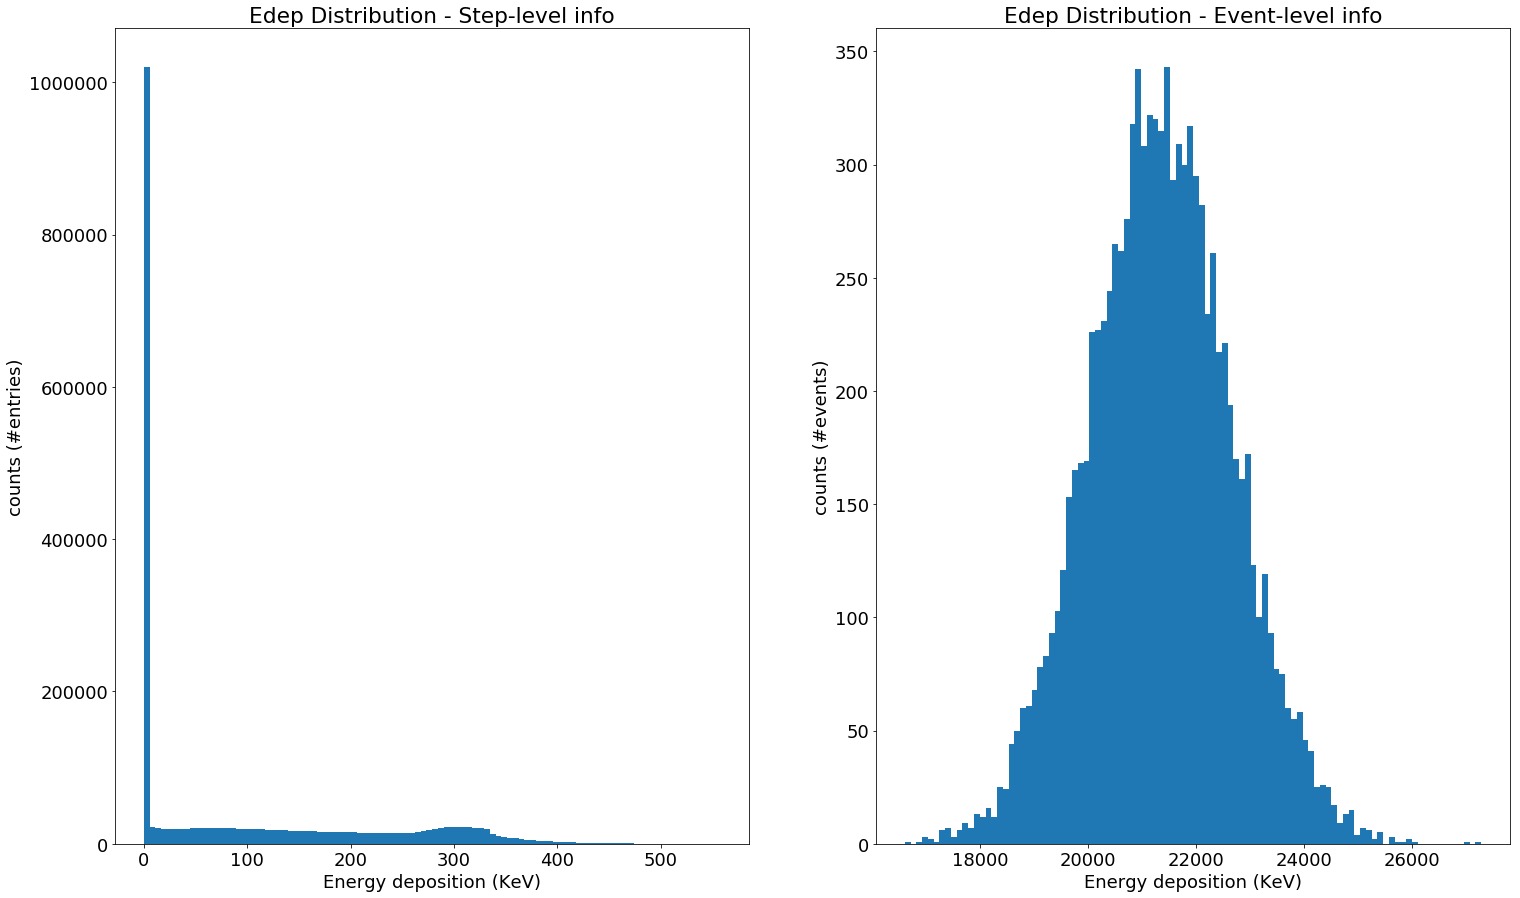

In [4]:
edep_stats = df.energydeposition.describe()

plt.subplot(1, 2, 1)
plt.hist(df.energydeposition, bins=100)
plt.title("Edep Distribution - Step-level info")
plt.xlabel("Energy deposition (KeV)")
plt.ylabel("counts (#entries)")

plt.subplot(1, 2, 2)
plt.hist(df.groupby("eventnumber").energydeposition.sum(), bins=100)
plt.title("Edep Distribution - Event-level info")
plt.xlabel("Energy deposition (KeV)")
plt.ylabel("counts (#events)")

plt.show()

# Analysis of time

In [6]:
df.time = df.time.astype("float")
df = df.sort_values("time")

In [12]:
pd.DataFrame([df.time.describe(), 
              df.energydeposition.describe(),
              df.groupby("eventnumber").energydeposition.sum().describe()], 
             index=["Time(steplevel)", "Edep(steplevel)", "CumEdep(eventlevel)"])

,count,mean,std,min,25%,50%,75%,max
Time(steplevel),2185013.0,1.223367e+19,1.225231e+19,2.490492e+12,3.514346e+18,8.463270e+18,1.694953e+19,1.585198e+20
Edep(steplevel),2185013.0,9.765940e+01,1.219257e+02,8.003553e-08,6.314272e-03,2.534614e+01,1.878591e+02,5.578690e+02
CumEdep(eventlevel),10000.0,2.133870e+04,1.323126e+03,1.660470e+04,2.044840e+04,2.133021e+04,2.221825e+04,2.727629e+04


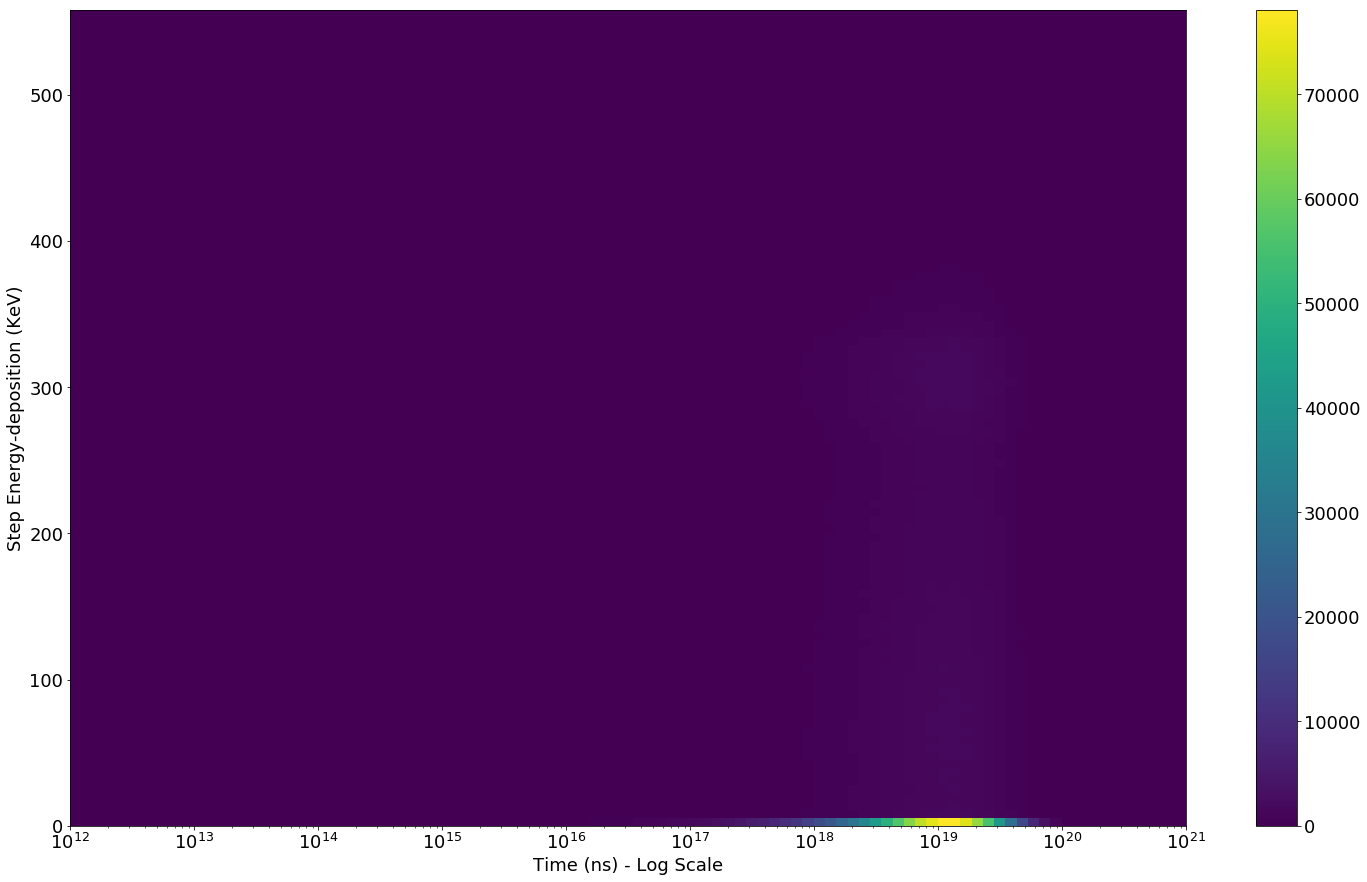

In [65]:
time_bins = np.logspace(12, 21, 100)
plt.hist2d(df.time, df.energydeposition, bins=[time_bins, 100])
plt.colorbar()
plt.xscale("log")
plt.xlabel("Time (ns) - Log Scale")
plt.ylabel("Step Energy-deposition (KeV)")
plt.show()

In [18]:
first_edep_xevent = df.groupby("eventnumber").time.first()

In [20]:
time = np.zeros(len(df))
import time as t
begin = t.time()
for i, (idx, row) in enumerate(df.iterrows()):
    if i%100000==0:
        print("Row {} - {} sec".format(i, t.time()-begin))
    time[i] = row.time - first_edep_xevent.loc[row.eventnumber]
time

Row 0 - 1.206336259841919 sec
Row 100000 - 18.263253927230835 sec
Row 200000 - 34.51765823364258 sec
Row 300000 - 49.74561381340027 sec
Row 400000 - 64.41392755508423 sec
Row 500000 - 79.51889085769653 sec
Row 600000 - 94.51401782035828 sec
Row 700000 - 109.55279588699341 sec
Row 800000 - 124.5605399608612 sec
Row 900000 - 140.37473464012146 sec
Row 1000000 - 155.39199781417847 sec
Row 1100000 - 170.29280376434326 sec
Row 1200000 - 185.3359136581421 sec
Row 1300000 - 200.90477395057678 sec
Row 1400000 - 215.95008969306946 sec
Row 1500000 - 231.5259611606598 sec
Row 1600000 - 246.62441873550415 sec
Row 1700000 - 261.78871178627014 sec
Row 1800000 - 277.2939808368683 sec
Row 1900000 - 292.77618169784546 sec
Row 2000000 - 307.86866307258606 sec
Row 2100000 - 323.6115047931671 sec


array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       1.53999817e+20, 1.58517433e+20, 1.58517433e+20])

In [21]:
df['time_net'] = time.tolist()
df.head()

,PID,ParentTrackID,energydeposition,kineticenergy,time,x,y,z,px,py,pz,eventnumber,tracknumber,creatorprocess,parentnucleusPID,time_net
1831458,11,1,331.310504,0.0,2.490492e+12,192.364572,-145.774623,-218.762336,-0.322923,-0.304791,-0.896004,8064,4,eIoni,1000180390,0.000000
1831459,1000190390,1,0.009828,0.0,2.490492e+12,192.364572,-145.774623,-218.762336,0.384465,0.109226,0.916655,8064,2,ionIoni,1000190390,0.000000
487377,11,1,70.324083,0.0,5.821026e+12,-207.382445,394.517073,796.755997,0.859559,-0.119416,0.496888,2947,4,eIoni,1000180390,0.000000
487378,1000190390,1,0.004032,0.0,5.821026e+12,-207.382445,394.517073,796.755997,-0.771194,-0.515805,0.373103,2947,2,ionIoni,1000190390,0.000977
1523844,11,1,198.792590,0.0,1.983894e+13,-38.038719,171.610113,563.068261,0.113810,0.506562,-0.854659,7151,4,eIoni,1000180390,0.000000


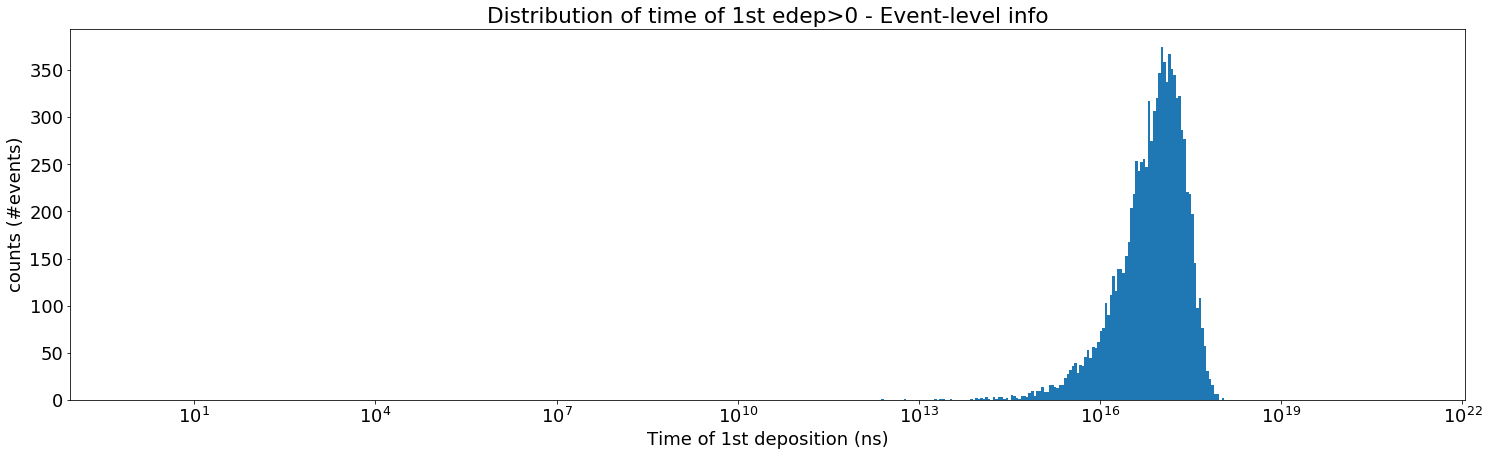

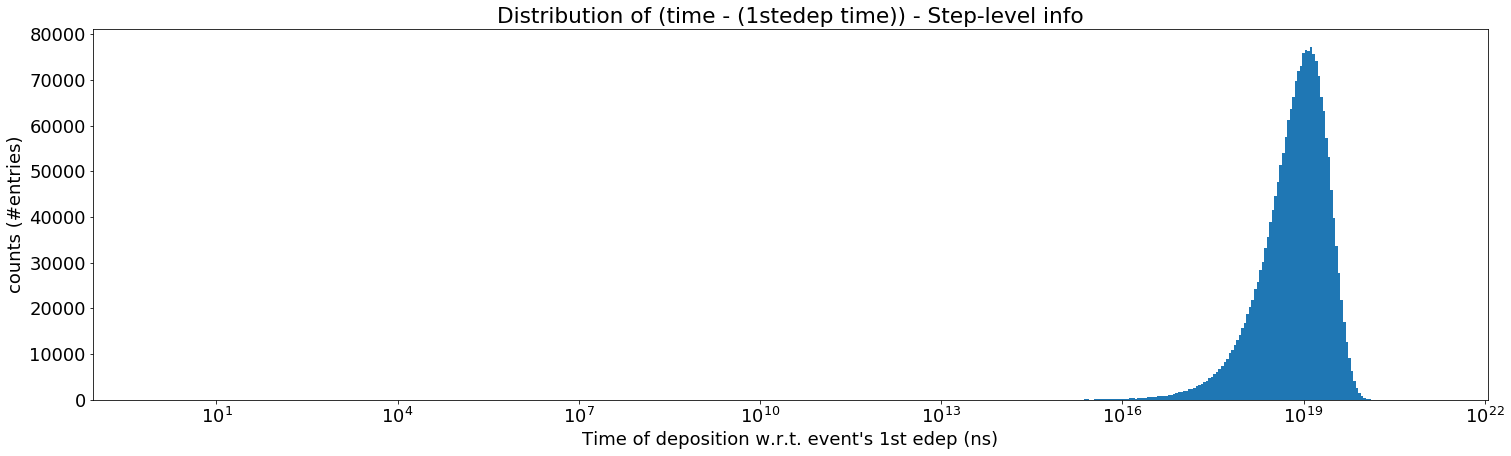

In [57]:
plt.subplot(2, 1, 1)
plt.hist(first_edep_xevent, bins=time_bins)
plt.xscale("log")
plt.title("Distribution of time of 1st edep>0 - Event-level info")
plt.xlabel("Time of 1st deposition (ns)")
plt.ylabel("counts (#events)")
plt.show()

plt.subplot(2, 1, 2)
plt.hist(df.time_net, bins=time_bins)
plt.xscale("log")
plt.title("Distribution of (time - (1stedep time)) - Step-level info")
plt.xlabel("Time of deposition w.r.t. event's 1st edep (ns)")
plt.ylabel("counts (#entries)")
plt.show()


In [22]:
pd.DataFrame([df.time.describe(), df.time_net.describe()], index=["Time(step)", "Time Net(step)"])

,count,mean,std,min,25%,50%,75%,max
Time(step),2185013.0,1.223367e+19,1.225231e+19,2.490492e+12,3.514346e+18,8.463270e+18,1.694953e+19,1.585198e+20
Time Net(step),2185013.0,1.210878e+19,1.225181e+19,0.000000e+00,3.387814e+18,8.337891e+18,1.682618e+19,1.585174e+20


In [56]:
lst_describes = []
indices = []
nevents_in_interval = []
for i, ex in enumerate(range(16, 21)):
    if i==0:
        nevents_in_interval.append(df[df.time<10**ex].eventnumber.nunique())
        lst_describes.append(df[df.time<10**ex].energydeposition.describe())
        indices.append("Time<10e{}".format(ex))
    else:
        nevents_in_interval.append(df[df.time<10**ex].eventnumber.nunique())
        lst_describes.append(df[(df.time>=10**(ex-1)) & (df.time<10**ex)].energydeposition.describe())
        indices.append("10e{}<=Time<10e{}".format(ex-1, ex))
time_parts = pd.DataFrame(lst_describes, index=indices)
time_parts = time_parts.rename(columns={"count": "#entries"})
time_parts.insert(1, "#events", nevents_in_interval)
time_parts

,#entries,#events,mean,std,min,25%,50%,75%,max
Time<10e16,1872.0,798,98.072864,121.636574,2.735032e-05,0.006295,25.342166,186.292329,516.957036
10e16<=Time<10e17,16018.0,5441,97.819934,122.654368,1.650187e-05,0.006395,24.933584,187.853390,529.937769
10e17<=Time<10e18,153966.0,9998,97.801900,122.062561,8.003553e-08,0.006324,25.930789,188.742666,557.868952
10e18<=Time<10e19,1048682.0,10000,97.616700,121.873072,1.789886e-06,0.006307,25.294979,187.768722,557.730868
10e19<=Time<10e20,963850.0,10000,97.681044,121.951766,9.895302e-07,0.006320,25.316619,187.856056,554.671782


In [69]:
event8064 = df[df.eventnumber==8064]
event8064

,PID,ParentTrackID,energydeposition,kineticenergy,time,x,y,z,px,py,pz,eventnumber,tracknumber,creatorprocess,parentnucleusPID,time_net
1831458,11,1,331.310504,0.000000,2.490492e+12,192.364572,-145.774623,-218.762336,-0.322923,-0.304791,-0.896004,8064,4,eIoni,1000180390,0.000000e+00
1831459,1000190390,1,0.009828,0.000000,2.490492e+12,192.364572,-145.774623,-218.762336,0.384465,0.109226,0.916655,8064,2,ionIoni,1000190390,0.000000e+00
345398,11,1,312.073841,0.000000,1.253377e+16,-44.160152,-180.616042,-456.471710,0.204277,-0.438305,-0.875305,8064,4,eIoni,1000180390,1.253127e+16
345399,1000190390,1,0.006060,0.000000,1.253377e+16,-44.160152,-180.616042,-456.471710,-0.374243,0.095322,0.922419,8064,2,ionIoni,1000190390,1.253127e+16
1197844,11,1,3.634263,0.000000,3.143756e+16,99.997453,448.473149,-674.030380,0.264213,0.437625,-0.859462,8064,4,eIoni,1000180390,3.143507e+16
1197843,11,1,353.854021,3.634263,3.143756e+16,99.956707,448.305682,-674.300650,0.264213,0.437625,-0.859462,8064,4,eIoni,1000180390,3.143507e+16
1197845,1000190390,1,0.011172,0.000000,3.143756e+16,99.956707,448.305682,-674.300650,-0.128757,-0.586387,-0.799732,8064,2,ionIoni,1000190390,3.143507e+16
1853399,11,1,31.300038,0.000000,3.577675e+16,-165.635754,354.644842,742.465377,0.697533,0.633657,-0.334554,8064,4,eIoni,1000180390,3.577426e+16
1853400,1000190390,1,0.004743,0.000000,3.577675e+16,-165.635754,354.644842,742.465377,0.308392,-0.663993,0.681181,8064,2,ionIoni,1000190390,3.577426e+16
170254,11,1,53.339855,0.000000,3.180995e+17,493.404575,-61.015968,-44.481782,-0.812699,-0.546818,-0.201274,8064,4,eIoni,1000180390,3.180970e+17
